Step 1: Data Loading & setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans

from tqdm import tqdm
import json

# For cleaner plots
sns.set(style="whitegrid")


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Update path as per your Drive location
json_file_path = '/content/drive/MyDrive/user-wallet-transactions.json'

# Load JSON (may take time depending on file size)
with open(json_file_path, 'r') as f:
    data = json.load(f)

# Normalize nested structure into flat DataFrame
df = pd.json_normalize(data)

# Show structure for understanding
print(df.shape)
df.head()


(100000, 35)


,userWallet,network,protocol,txHash,logId,timestamp,blockNumber,action,__v,_id.$oid,...,actionData.repayerId,actionData.liquidatorId,actionData.collateralAmount,actionData.collateralAssetPriceUSD,actionData.principalAmount,actionData.borrowAssetPriceUSD,actionData.collateralReserveId,actionData.collateralReserveSymbol,actionData.principalReserveId,actionData.principalReserveSymbol
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,polygon,aave_v2,0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6...,0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6...,1629178166,1629178166,deposit,0,681d38fed63812d4655f571a,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0x000000000051d07a4fb3bd10121a343d85818da6,polygon,aave_v2,0xe6fc162c86b2928b0ba9b82bda672763665152b9de9d...,0xe6fc162c86b2928b0ba9b82bda672763665152b9de9d...,1621525013,1621525013,deposit,0,681aa70dd6df53021cc6f3c0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0x000000000096026fb41fc39f9875d164bd82e2dc,polygon,aave_v2,0xe2d7eb815c89331a734ed6f204a06c385a1b39040baa...,0xe2d7eb815c89331a734ed6f204a06c385a1b39040baa...,1627118913,1627118913,deposit,0,681d04c2d63812d4654c733e,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0x000000000096026fb41fc39f9875d164bd82e2dc,polygon,aave_v2,0x0d63a2eacd82b82f868db825ea7385e6bd8d046ee729...,0x0d63a2eacd82b82f868db825ea7385e6bd8d046ee729...,1627773318,1627773318,deposit,0,681d133bd63812d46551b6ef,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0x0000000000e189dd664b9ab08a33c4839953852c,polygon,aave_v2,0x590eabb812c5006a6f4766f44e6e9d3ad0b5b563de69...,0x590eabb812c5006a6f4766f44e6e9d3ad0b5b563de69...,1618845907,1618845907,redeemunderlying,0,681899e4ba49fc91cf2f4454,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Step 2: Data Exploration and Cleaning

In [ ]:
pd.set_option('display.max_columns', 50)
print(df.columns.tolist())


['userWallet', 'network', 'protocol', 'txHash', 'logId', 'timestamp', 'blockNumber', 'action', '__v', '_id.$oid', 'actionData.type', 'actionData.amount', 'actionData.assetSymbol', 'actionData.assetPriceUSD', 'actionData.poolId', 'actionData.userId', 'createdAt.$date', 'updatedAt.$date', 'actionData.toId', 'actionData.borrowRateMode', 'actionData.borrowRate', 'actionData.variableTokenDebt', 'actionData.stableTokenDebt', 'actionData.callerId', 'actionData.useATokens', 'actionData.repayerId', 'actionData.liquidatorId', 'actionData.collateralAmount', 'actionData.collateralAssetPriceUSD', 'actionData.principalAmount', 'actionData.borrowAssetPriceUSD', 'actionData.collateralReserveId', 'actionData.collateralReserveSymbol', 'actionData.principalReserveId', 'actionData.principalReserveSymbol']


In [ ]:
print("Unique actions:", df['action'].unique())
print("\nAction counts:\n", df['action'].value_counts())


Unique actions: ['deposit' 'redeemunderlying' 'borrow' 'repay' 'liquidationcall']

Action counts:
 action
deposit             37808
redeemunderlying    32305
borrow              17086
repay               12553
liquidationcall       248
Name: count, dtype: int64


In [ ]:
print(df[['userWallet', 'timestamp', 'action', 'actionData.amount', 'actionData.assetPriceUSD']].isnull().sum())


userWallet                  0
timestamp                   0
action                      0
actionData.amount           0
actionData.assetPriceUSD    0
dtype: int64


In [ ]:
# Convert relevant fields to numeric
df['actionData.amount'] = pd.to_numeric(df['actionData.amount'], errors='coerce')
df['actionData.assetPriceUSD'] = pd.to_numeric(df['actionData.assetPriceUSD'], errors='coerce')


In [ ]:
df['amount_usd'] = df['actionData.amount'] * df['actionData.assetPriceUSD']


In [ ]:
df[['actionData.amount', 'actionData.assetPriceUSD', 'amount_usd']].describe()


,actionData.amount,actionData.assetPriceUSD,amount_usd
count,1.000000e+05,100000.000000,1.000000e+05
mean,6.544795e+21,1997.901165,1.167114e+22
std,1.264935e+23,8166.822331,1.628296e+23
min,0.000000e+00,0.000000,0.000000e+00
25%,2.347008e+08,0.999311,4.997491e+08
50%,5.204440e+11,1.003320,7.331946e+12
75%,2.499973e+19,1.474938,1.959414e+20
max,1.273000e+25,64664.127500,1.274226e+25


Step -3: Feature Engineering


In [ ]:
#  Add a 'date' column for activity period calculation
df['date'] = pd.to_datetime(df['timestamp'], unit='s')

#  Group by 'userWallet'
group = df.groupby('userWallet')




/tmp/ipython-input-14-2569745283.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  wallet_features['total_deposit_usd'] = group.apply(lambda x: x.loc[x['action'] == 'deposit', 'amount_usd'].sum())
/tmp/ipython-input-14-2569745283.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  wallet_features['total_borrow_usd'] = group.apply(lambda x: x.loc[x['action'] == 'borrow', 'amount_usd'].sum())
/tmp/ipython

,userWallet,num_transactions,num_deposit,num_borrow,num_repay,num_redeemunderlying,num_liquidationcall,total_deposit_usd,total_borrow_usd,total_repay_usd,total_redeem_usd,total_liquidation_usd,repay_borrow_ratio,liquidation_rate,borrow_deposit_ratio,active_days
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,1,1,0,0,0,0,1.987664e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.000000,1
1,0x000000000051d07a4fb3bd10121a343d85818da6,1,1,0,0,0,0,2.856945e+20,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.000000,1
2,0x000000000096026fb41fc39f9875d164bd82e2dc,2,2,0,0,0,0,5.152311e+15,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.000000,8
3,0x0000000000e189dd664b9ab08a33c4839953852c,17,0,0,0,17,0,0.000000e+00,0.000000e+00,0.000000e+00,9.803600e+20,0.0,0.000000e+00,0.0,0.000000,130
4,0x0000000002032370b971dabd36d72f3e5a7bf1ee,399,250,15,4,130,0,2.065773e+23,6.029762e+22,7.015026e+10,1.128745e+23,0.0,1.163400e-12,0.0,0.291889,133


In [ ]:
#  Initialize feature dataframe
wallet_features = pd.DataFrame()
wallet_features['num_transactions'] = group.size()
wallet_features['num_deposit'] = group['action'].apply(lambda x: (x == 'deposit').sum())
wallet_features['num_borrow'] = group['action'].apply(lambda x: (x == 'borrow').sum())
wallet_features['num_repay'] = group['action'].apply(lambda x: (x == 'repay').sum())
wallet_features['num_redeemunderlying'] = group['action'].apply(lambda x: (x == 'redeemunderlying').sum())
wallet_features['num_liquidationcall'] = group['action'].apply(lambda x: (x == 'liquidationcall').sum())



In [ ]:
#  USD volume-based features
wallet_features['total_deposit_usd'] = group.apply(lambda x: x.loc[x['action'] == 'deposit', 'amount_usd'].sum())
wallet_features['total_borrow_usd'] = group.apply(lambda x: x.loc[x['action'] == 'borrow', 'amount_usd'].sum())
wallet_features['total_repay_usd'] = group.apply(lambda x: x.loc[x['action'] == 'repay', 'amount_usd'].sum())
wallet_features['total_redeem_usd'] = group.apply(lambda x: x.loc[x['action'] == 'redeemunderlying', 'amount_usd'].sum())
wallet_features['total_liquidation_usd'] = group.apply(lambda x: x.loc[x['action'] == 'liquidationcall', 'amount_usd'].sum())



In [ ]:
#  Derived ratios
wallet_features['repay_borrow_ratio'] = wallet_features['total_repay_usd'] / (wallet_features['total_borrow_usd'] + 1)
wallet_features['liquidation_rate'] = wallet_features['num_liquidationcall'] / (wallet_features['num_borrow'] + 1)
wallet_features['borrow_deposit_ratio'] = wallet_features['total_borrow_usd'] / (wallet_features['total_deposit_usd'] + 1)



In [ ]:
#  Activity days
wallet_features['first_tx'] = group['date'].min()
wallet_features['last_tx'] = group['date'].max()
wallet_features['active_days'] = (wallet_features['last_tx'] - wallet_features['first_tx']).dt.days + 1



In [ ]:
#  Drop helper columns if not needed
wallet_features = wallet_features.drop(['first_tx', 'last_tx'], axis=1)

# Check the feature matrix
wallet_features.reset_index(inplace=True)
wallet_features.head()

Step 4: Rule-based Scoring

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Columns to scale
cols_to_scale = [
    'total_deposit_usd', 'total_borrow_usd', 'total_repay_usd',
    'liquidation_rate', 'repay_borrow_ratio', 'borrow_deposit_ratio',
    'active_days'
]



,userWallet,rule_based_score
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,171.170779
1,0x000000000051d07a4fb3bd10121a343d85818da6,171.172265
2,0x000000000096026fb41fc39f9875d164bd82e2dc,174.052947
3,0x0000000000e189dd664b9ab08a33c4839953852c,224.285021
4,0x0000000002032370b971dabd36d72f3e5a7bf1ee,227.027993


In [ ]:
# Replace inf with nan and fill with 0 before scaling
wallet_features.replace([np.inf, -np.inf], np.nan, inplace=True)
wallet_features.fillna(0, inplace=True)

scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(wallet_features[cols_to_scale])
scaled_df = pd.DataFrame(scaled_features, columns=[col+'_scaled' for col in cols_to_scale])



In [ ]:
# Concatenate scaled columns
wallet_features = pd.concat([wallet_features, scaled_df], axis=1)



In [ ]:
# Define weights
w_deposit = 0.25
w_borrow = 0.20
w_repay = 0.20
w_liquidation = 0.15
w_repay_borrow_ratio = 0.10
w_borrow_deposit_ratio = 0.05
w_active_days = 0.05



In [ ]:

# Compute score
wallet_features['rule_based_score'] = (
    w_deposit * wallet_features['total_deposit_usd_scaled'] +
    w_borrow * wallet_features['total_borrow_usd_scaled'] +
    w_repay * wallet_features['total_repay_usd_scaled'] -
    w_liquidation * wallet_features['liquidation_rate_scaled'] +
    w_repay_borrow_ratio * wallet_features['repay_borrow_ratio_scaled'] +
    w_borrow_deposit_ratio * wallet_features['borrow_deposit_ratio_scaled'] +
    w_active_days * wallet_features['active_days_scaled']
)



In [ ]:
# Scale to 0-1000
wallet_features['rule_based_score'] = (wallet_features['rule_based_score'] - wallet_features['rule_based_score'].min()) / \
                                      (wallet_features['rule_based_score'].max() - wallet_features['rule_based_score'].min()) * 1000



In [ ]:
# Display results
wallet_features[['userWallet', 'rule_based_score']].head()

KMeans Clustering ML Pipeline


In [ ]:
from sklearn.cluster import KMeans

# Features to use
cluster_features = wallet_features[
    ['total_deposit_usd_scaled', 'total_borrow_usd_scaled', 'total_repay_usd_scaled',
     'liquidation_rate_scaled', 'repay_borrow_ratio_scaled', 'borrow_deposit_ratio_scaled',
     'active_days_scaled']
]




,userWallet,rule_based_score,cluster,ml_score
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,171.170779,0,200
1,0x000000000051d07a4fb3bd10121a343d85818da6,171.172265,0,200
2,0x000000000096026fb41fc39f9875d164bd82e2dc,174.052947,0,200
3,0x0000000000e189dd664b9ab08a33c4839953852c,224.285021,3,800
4,0x0000000002032370b971dabd36d72f3e5a7bf1ee,227.027993,3,800


In [ ]:
# Fit KMeans
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
wallet_features['cluster'] = kmeans.fit_predict(cluster_features)

# Map clusters to score bands
# Compute cluster-wise means to determine ordering
cluster_order = wallet_features.groupby('cluster')['total_deposit_usd_scaled'].mean().sort_values().index.tolist()



In [ ]:
# Assign scores based on cluster rank
score_map = {}
score_bands = [200, 400, 600, 800, 1000]  # or adjust bands as needed
for idx, cluster_label in enumerate(cluster_order):
    score_map[cluster_label] = score_bands[idx]

wallet_features['ml_score'] = wallet_features['cluster'].map(score_map)

# Preview
wallet_features[['userWallet', 'rule_based_score', 'cluster', 'ml_score']].head()

Step 6: Generating Analysis Plots

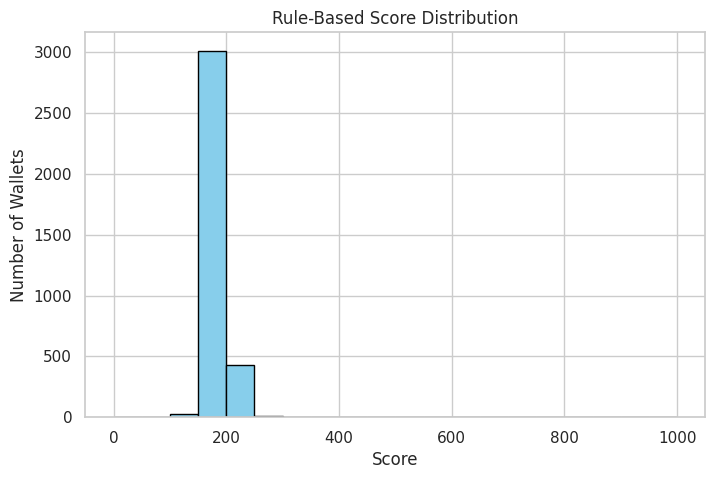

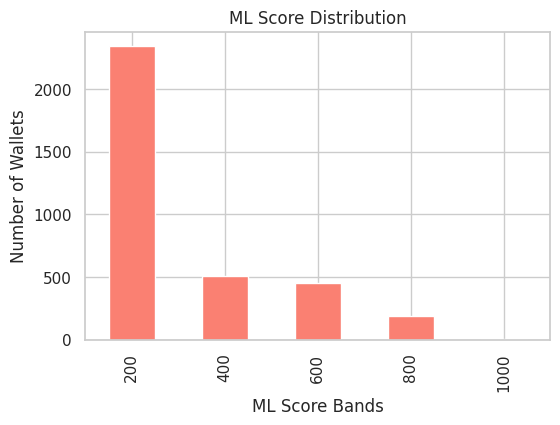

       rule_based_score     ml_score
count       3497.000000  3497.000000
mean         180.608692   314.440949
std           28.681798   183.533158
min            0.000000   200.000000
25%          171.170779   200.000000
50%          171.994255   200.000000
75%          183.973954   400.000000
max         1000.000000  1000.000000


In [ ]:
import matplotlib.pyplot as plt

# Rule-based score histogram
plt.figure(figsize=(8,5))
plt.hist(wallet_features['rule_based_score'], bins=20, color='skyblue', edgecolor='black')
plt.title('Rule-Based Score Distribution')
plt.xlabel('Score')
plt.ylabel('Number of Wallets')
plt.grid(True)
plt.show()

# ML score bar plot
plt.figure(figsize=(6,4))
wallet_features['ml_score'].value_counts().sort_index().plot(kind='bar', color='salmon')
plt.title('ML Score Distribution')
plt.xlabel('ML Score Bands')
plt.ylabel('Number of Wallets')
plt.grid(True)
plt.show()

# Basic descriptive stats for README
print(wallet_features[['rule_based_score', 'ml_score']].describe())
